## TruLens vs RAGAS vs MLFlow performance comparison for groundedness

In this notebook, we analyze the performance of TruLens current groundedness feedback function and its comparable or equivalent implementations from other evaluation frameworks using the same model for LLM-as-judges. 


### Definitions
1. TruLens `groundedness`: evaluates whether a response is fully supported by the source or retrieved contexts.

2. RAGAS `faithfulness`: measures the factual consistency of the generated answer against the given context [source](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)

3. MLflow `faithfulness`: Faithfulness will be assessed based on how factually consistent the output is to the context
[source](https://mlflow.org/docs/latest/python_api/mlflow.metrics.html#mlflow.metrics.genai.faithfulness)





In [ ]:
# ! pip install trulens-core trulens-providers-openai ragas mlflow

In [1]:
import os

from trulens.connectors.snowflake import SnowflakeConnector
from trulens.core.session import TruSession

# os.environ["OPENAI_API_KEY"] = "sk-..."

connection_params = {
    "account": os.environ.get("SNOWFLAKE_ACCOUNT"),
    "user": os.environ.get("SNOWFLAKE_USER"),
    "password": os.environ.get("SNOWFLAKE_USER_PASSWORD"),
    "database": os.environ.get("SNOWFLAKE_DATABASE"),
    "schema": os.environ.get("SNOWFLAKE_SCHEMA"),
    "warehouse": os.environ.get("SNOWFLAKE_WAREHOUSE"),
    "role": os.environ.get("SNOWFLAKE_ROLE"),
    "init_server_side": False,  # Set to True to enable server side feedback functions
}

# connector = SnowflakeConnector(**connection_params)
# session = TruSession(connector=connector)

session = TruSession()
session.reset_database()

/opt/anaconda3/envs/trulens/lib/python3.11/site-packages/snowflake/sqlalchemy/base.py:1068: SAWarning: The GenericFunction 'flatten' is already registered and is going to be overridden.
  functions.register_function("flatten", flatten)


🦑 Initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.


Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]


### Prepare 3 public benchmark datasets: QAGS CNN/Daily Mail, QAGS XSum, and SummEval

In [ ]:
import pandas as pd
from trulens.benchmark.benchmark_frameworks.experiments.dataset_preprocessing import (
    generate_qags_golden_set_groundedness,
)
from trulens.benchmark.benchmark_frameworks.experiments.dataset_preprocessing import (
    generate_summeval_groundedness_golden_set,
)

qags_cnn_dm = pd.DataFrame(
    list(generate_qags_golden_set_groundedness("data/qags_mturk_cnndm.jsonl"))
)

qags_xsum = pd.DataFrame(
    list(generate_qags_golden_set_groundedness("data/qags_mturk_xsum.jsonl"))
)

summeval = pd.DataFrame(
    list(
        generate_summeval_groundedness_golden_set(
            "data/summeval_test.json", max_samples_per_bucket=200
        )
    )
)


summeval_true_labels = [row["expected_score"] for _, row in summeval.iterrows()]

summeval_true_labels_binary = [
    1 if label >= 0.5 else 0 for label in summeval_true_labels
]

qags_cnn_dm_true_labels = [
    row["expected_score"] for _, row in qags_cnn_dm.iterrows()
]

qags_cnn_dm_true_labels_binary = [
    1 if label >= 0.5 else 0 for label in qags_cnn_dm_true_labels
]

qags_xsum_true_labels = [
    row["expected_score"] for _, row in qags_xsum.iterrows()
]

qags_xsum_true_labels_binary = [
    1 if label >= 0.5 else 0 for label in qags_xsum_true_labels
]
combined_dataset = pd.concat(
    [qags_cnn_dm, qags_xsum, summeval], ignore_index=False
)
combined_true_labels = (
    qags_cnn_dm_true_labels + qags_xsum_true_labels + summeval_true_labels
)

assert len(combined_dataset) == len(combined_true_labels)
print(f"Total number of samples: {len(combined_dataset)}")

In [ ]:
combined_dataset

In [ ]:
from trulens.benchmark.benchmark_frameworks.experiments.dataset_preprocessing import (
    visualize_expected_score_distribution,
)

# making sure the distribution of the expected scores is as balanced as possible for the datasets
visualize_expected_score_distribution(combined_true_labels)

## Setup experiments with TruLens `TruBasicApp` recorder

In [ ]:
session.reset_database()

In [28]:
from trulens.core import Provider


THRESHOLD = 0.33
class CustomTermFeedback(Provider):
    def true_positive(self, output: str) -> float:
        feedback_score, gt_score = float(output.split(";")[0]), float(output.split(";")[1])
        binary_score = 1 if feedback_score >= 0.5 else 0
        binary_gt_score = 1 if gt_score >= THRESHOLD else 0
        return 1.0 if binary_score == 1 and binary_gt_score == 1 else 0.0
        
    def true_negative(self, output: str) -> float:
        feedback_score, gt_score = float(output.split(";")[0]), float(output.split(";")[1])
        binary_score = 1 if feedback_score >= 0.5 else 0
        binary_gt_score = 1 if gt_score >= THRESHOLD else 0
        return 1.0 if binary_score == 0 and binary_gt_score == 0 else 0.0

    def false_positive(self, output: str) -> float:
        feedback_score, gt_score = float(output.split(";")[0]), float(output.split(";")[1])
        binary_score = 1 if feedback_score >= 0.5 else 0
        binary_gt_score = 1 if gt_score >= THRESHOLD else 0
        return 1.0 if binary_score == 1 and binary_gt_score == 0 else 0.0
    def false_negative(self, output: str) -> float:
        feedback_score, gt_score = float(output.split(";")[0]), float(output.split(";")[1])
        binary_score = 1 if feedback_score >= 0.5 else 0
        binary_gt_score = 1 if gt_score >= THRESHOLD else 0
        return 1.0 if binary_score == 0 and binary_gt_score == 1 else 0.0
    
    def term_absolute_error(self, output: str) -> float:
        feedback_score, gt_score = float(output.split(";")[0]), float(output.split(";")[1])
        return abs(feedback_score - gt_score)     

In [ ]:
from datasets import Dataset
import mlflow
from mlflow.metrics.genai import answer_relevance as answer_relevance_mlflow
from mlflow.metrics.genai import faithfulness as faithfulness_mlflow
from mlflow.metrics.genai import relevance as context_relevance_mlflow
# from ragas import evaluate
# from ragas.cost import get_token_usage_for_openai
# from ragas.llms import llm_factory
# from ragas.metrics import faithfulness as faithfulness_ragas
from trulens.apps.basic import TruBasicApp
from trulens.core import Feedback
from trulens.providers.openai import OpenAI

OPENAI_LLM_NAME = "gpt-4o-mini"
gpt_4o_mini = OpenAI(model_engine=OPENAI_LLM_NAME)


# def trulens_groundedness(context: str, response: str, gt_score: float) -> str:
#     trulens_groundedness_res = (
#         gpt_4o_mini.groundedness_measure_with_cot_reasons(
#             source=context, statement=response, use_sent_tokenize=True
#         )
#     )
#     return f"{trulens_groundedness_res[0]};{gt_score};{trulens_groundedness_res[1]}"


# langchain_llm = llm_factory(model=OPENAI_LLM_NAME)
# faithfulness_ragas.llm = langchain_llm


# def ragas_faithfulness(context: str, response: str, gt_score: float) -> str:
#     data_samples = {"question": [], "answer": [], "contexts": []}
#     data_samples["question"].append("dummy text")
#     data_samples["answer"].append(response)
#     data_samples["contexts"].append([context])
#     ragas_dataset = Dataset.from_dict(data_samples)

#     score_dict = evaluate(
#         ragas_dataset,
#         metrics=[faithfulness_ragas],
#         llm=langchain_llm,
#         token_usage_parser=get_token_usage_for_openai,
#     )

#     return f"{score_dict['faithfulness'][0]};{gt_score}"

# # not supplying any example as other metrics do zero-shot evaluation as well
# faithfulness_metric = faithfulness_mlflow(
#     model=f"openai:/{OPENAI_LLM_NAME}"
# )  
# context_relevance_metric = context_relevance_mlflow(
#     model=f"openai:/{OPENAI_LLM_NAME}"
# )

# answer_relevance_metric = answer_relevance_mlflow(
#     model=f"openai:/{OPENAI_LLM_NAME}"
# )

# def mlflow_context_relevance(query: str, context: str, response: str, gt_score: float) -> str:
#     eval_data = pd.DataFrame({
#         "inputs": [
#            query 
#         ],
#         "predictions": [response], # note that we are using the response as the prediction
#         "context": [context],
#     })

#     with mlflow.start_run() as _:
#         results = mlflow.evaluate(
#             data=eval_data,
#             predictions="predictions",
#             extra_metrics=[context_relevance_metric
#            ],
#             evaluators="default",
#         )

#     mlflow_context_relevance_score = results.metrics["relevance/v1/mean"]

#     mlflow_context_relevance_score_norm = (
#         mlflow_context_relevance_score - 1
#     ) / 4.0  # normalizing the score to be between 0 and 1

#     return f"{mlflow_context_relevance_score_norm};{gt_score}"

# def mlflow_answer_relevance(query: str, response: str, gt_score: float) -> str:
#     eval_data = pd.DataFrame({
#         "inputs": [query],
#         "predictions": [response],
#         "context": ["dummy text"],  # we are not using the context for answer relevance evaluation
#     })

#     with mlflow.start_run() as _:
#         results = mlflow.evaluate(
#             data=eval_data,
#             predictions="predictions",
#             extra_metrics=[answer_relevance_metric],
#             evaluators="default",
#         )

#     mlflow_answer_relevance_score = results.metrics["answer_relevance/v1/mean"]

#     mlflow_answer_relevance_score_norm = (
#         mlflow_answer_relevance_score - 1
#     ) / 4.0  # normalizing the score to be between 0 and 1

#     return f"{mlflow_answer_relevance_score_norm};{gt_score}"

# def mlflow_faithfulness(context: str, response: str, gt_score: float) -> str:
#     eval_data = pd.DataFrame({
#         "inputs": [
#             "dummy text"  # we are not using the inputs (user's queries) for faithfulness evaluation
#         ],
#         "predictions": [response],
#         "context": [context],
#     })

#     with mlflow.start_run() as _:
#         results = mlflow.evaluate(
#             data=eval_data,
#             predictions="predictions",
#             extra_metrics=[
#                 faithfulness_metric            
#             ],
#             evaluators="default",
#         )

#     mlflow_faithfulness_score = results.metrics["faithfulness/v1/mean"]

#     mlflow_faithfulness_score_norm = (
#         mlflow_faithfulness_score - 1
#     ) / 4.0  # normalizing the score to be between 0 and 1

#     return f"{mlflow_faithfulness_score_norm};{gt_score}"





def run_experiment_and_record(
    evaluate_func_wrapper, app_name, app_version, dataset_df, true_labels
):
    if len(dataset_df) != len(true_labels):
        raise ValueError("dataset df must have the same length as labels")

    tru_wrapped_basic_app = TruBasicApp(
        evaluate_func_wrapper,
        app_name=app_name,
        app_version=app_version,
        feedbacks=CUSTOM_FEEDBACK_FUNCS,
    )

    for i in range(len(dataset_df)):
        arg_1 = dataset_df.iloc[i]["query"]
        arg_2 = dataset_df.iloc[i]["expected_response"]
        arg_3 = true_labels[i]

        try:
            with tru_wrapped_basic_app as _:
                tru_wrapped_basic_app.app(arg_1, arg_2, arg_3)

        except Exception as e:
            print(
                f"Error {e} in run_feedback_experiment row {i} with first arg {arg_1} and second arg {arg_2}"
            )

In [ ]:
EXP_NAME = "competitive-analysis-10312024"
run_experiment_and_record(
    evaluate_func_wrapper=trulens_groundedness,
    app_version="trulens-groundedness",
    app_name=EXP_NAME,
    dataset_df=combined_dataset,
    true_labels=combined_true_labels,
)

run_experiment_and_record(
    evaluate_func_wrapper=ragas_faithfulness,
    app_version="ragas-faithfulness",
    app_name=EXP_NAME,
    dataset_df=combined_dataset,
    true_labels=combined_true_labels,
)

run_experiment_and_record(
    evaluate_func_wrapper=mlflow_faithfulness,
    app_version="mlflow-faithfulness",
    app_name=EXP_NAME,
    dataset_df=combined_dataset,
    true_labels=combined_true_labels,
)

In [ ]:
session.get_leaderboard()

In [ ]:
session.run_dashboard()

#### Note about column name mapping: in all our dataframes (CNN/DM, XSUM, and SummEval), the "expected_score" column is the ground truth (true) label for the groundedness score, query corresponds to the context, and expected_response corresponds to the response.

### MLflow Answer Relevance and Contex Relevance experiments 


In [ ]:
import random

from trulens.benchmark.benchmark_frameworks.dataset.beir_loader import (
    TruBEIRDataLoader,
)

random.seed(42)


def generate_ms_marco_context_relevance_benchmark_for_mlflow(
    file_path: str = "data/ms_marco_v2_1_val.parquet",
):
    df = pd.read_parquet(file_path, engine="pyarrow")  # or engine='fastparquet'

    for _, row in df.iterrows():
        assert len(row["passages"]["is_selected"]) == len(
            row["passages"]["passage_text"]
        )

        if sum(row["passages"]["is_selected"]) < 1:
            # currently we only consider sample with one passage marked as relevant (there are samples where zero passage_text is selected)
            continue
        for i, passage_text in enumerate(row["passages"]["passage_text"]):
            yield {
                "query_id": row["query_id"],
                "query": row["query"],
                "expected_response": row["answers"][0],
                "expected_context": passage_text,
                "expected_score": row["passages"]["is_selected"][
                    i
                ],  # Binary relevance
            }

ms_marco = list(generate_ms_marco_context_relevance_benchmark_for_mlflow(
))


score_1_entries = [entry for entry in ms_marco if entry["expected_score"] == 1]
score_0_entries = [entry for entry in ms_marco if entry["expected_score"] == 0]

# Calculate the number of samples needed from each group
num_samples_per_group = min(
    len(score_1_entries), len(score_0_entries), 150
)  # Sample 150 from each


sampled_score_1 = random.sample(score_1_entries, num_samples_per_group)
sampled_score_0 = random.sample(score_0_entries, num_samples_per_group)

# Combine and shuffle the samples to get a balanced dataset
balanced_sample = sampled_score_1 + sampled_score_0
random.shuffle(balanced_sample)

# Ensure the combined length is 300
assert len(balanced_sample) == 300

# Now you can use `balanced_sample` as your final dataset
print(
    f"Number of entries with expected_score = 1: {len([e for e in balanced_sample if e['expected_score'] == 1])}"
)
print(
    f"Number of entries with expected_score = 0: {len([e for e in balanced_sample if e['expected_score'] == 0])}"
)

ms_marco_balanced_sample_300 = pd.DataFrame(balanced_sample)


beir_data_loader = TruBEIRDataLoader(data_folder="./", dataset_name="hotpotqa")
hotpotqa = beir_data_loader.load_dataset_to_df(download=True)


hotpotqa_raw_subset = hotpotqa.sample(n=200, random_state=42)

all_responses = [
    (row["query"], row["expected_response"])
    for idx, row in hotpotqa_raw_subset.iterrows()
]


hotpotqa_subset_for_answer_relevance = [] 

for idx, row in hotpotqa_raw_subset.iterrows():
    # Positive examples for answer relevance
    hotpotqa_subset_for_answer_relevance.append({
        "query": row["query"],
        "expected_response": row["expected_response"],  # Positive response
        "expected_score": 1,  # Positive example, score = 1
    })

    # Negative examples for answer relevance (random unrelated response)
    negative_response = random.choice([
        r
        for q, r in all_responses
        if q != row["query"]  # Pick response from another query
    ])

    hotpotqa_subset_for_answer_relevance.append({
        "query": row["query"],
        "expected_response": negative_response,  # Negative response
        "expected_score": 0,  # Negative example, score = 0
    })


hotpotqa_subset_for_answer_relevance_true_labels = [
    entry["expected_score"] for entry in hotpotqa_subset_for_answer_relevance
]

hotpotqa_subset_for_answer_relevance = pd.DataFrame(
    hotpotqa_subset_for_answer_relevance
)

In [49]:
ms_marco_balanced_sample_300_true_labels = ms_marco_balanced_sample_300["expected_score"]


In [ ]:
hotpotqa_subset_for_answer_relevance

In [ ]:
ms_marco_balanced_sample_300

In [29]:
import os

from trulens.connectors.snowflake import SnowflakeConnector
from trulens.core.session import TruSession

# os.environ["OPENAI_API_KEY"] = "sk-..."


session = TruSession()
session.reset_database()


Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]


In [ ]:

tru_wrapped_answer_relevance_app = TruBasicApp(
    mlflow_answer_relevance,
    app_name="competitive-analysis-mlflow-11022024",
    app_version="mlflow-answer-relevance",
    feedbacks=CUSTOM_FEEDBACK_FUNCS,
)

for i in range(len(hotpotqa_subset_for_answer_relevance)):
    arg_1 = hotpotqa_subset_for_answer_relevance.iloc[i]["query"]
    arg_2 = hotpotqa_subset_for_answer_relevance.iloc[i]["expected_response"]
    arg_3 = hotpotqa_subset_for_answer_relevance_true_labels[i]

    try:
        with tru_wrapped_answer_relevance_app as _:
            tru_wrapped_answer_relevance_app.app(arg_1, arg_2, arg_3)

    except Exception as e:
        print(
            f"Error {e} in run_feedback_experiment row {i} with first arg {arg_1} and second arg {arg_2}"
        )

In [ ]:
ms_marco_balanced_sample_300

In [11]:
from trulens.apps.basic import TruBasicApp

tru_wrapped_answer_relevance_app = TruBasicApp(
    mlflow_context_relevance,
    app_name="competitive-analysis-mlflow-11022024",
    app_version="mlflow-context-relevance",
    feedbacks=CUSTOM_FEEDBACK_FUNCS,
)

for i in range(len(ms_marco_balanced_sample_300)):
    arg_1 = ms_marco_balanced_sample_300.iloc[i]["query"]
    arg_2 = ms_marco_balanced_sample_300.iloc[i]["expected_context"]
    arg_3 = ms_marco_balanced_sample_300.iloc[i]["expected_response"]
    arg_4 = ms_marco_balanced_sample_300_true_labels[i]

    try:
        with tru_wrapped_answer_relevance_app as _:
            tru_wrapped_answer_relevance_app.app(arg_1, arg_2, arg_3, arg_4)

    except Exception as e:
        print(
            f"Error {e} in run_feedback_experiment row {i} with first arg {arg_1} and second arg {arg_2} and third arg {arg_3}"
        )

NameError: name 'mlflow_context_relevance' is not defined

In [ ]:
session.get_leaderboard()

### Benchmark context relevance with Python ir-datasets package 

In [36]:
import snowflake.connector
from snowflake.snowpark.session import Session
from trulens.providers.cortex import Cortex
from trulens.providers.litellm import LiteLLM
from trulens.providers.openai import OpenAI

trulens_ollama_provider = LiteLLM(
    model_engine="ollama/llama3.1:8b", api_base="http://localhost:11434"
)

snowpark_session = Session.builder.configs(connection_params).create()

gpt_4o = OpenAI(model_engine="gpt-4o")
gpt_4o_mini = OpenAI(model_engine="gpt-4o-mini")
# snowflake_arctic = Cortex(snowpark_session, model_engine="snowflake-arctic")
# mistral_large = Cortex(snowflake.connector.connect(**connection_params), model_engine="mistral-large")
# llama3_1_8b = Cortex(snowflake.connector.connect(**connection_params), model_engine="llama3.1-8b")

llama3_1_8b = LiteLLM(
    model_engine="ollama/llama3.1:8b", api_base="http://localhost:11434"
)
PROVIDERS = [gpt_4o, gpt_4o_mini, llama3_1_8b]


In [37]:


def trulens_context_relevance(provider, query: str, context: str, gt_score: float) -> str:
    trulens_context_relevance_res = (
        provider.context_relevance_with_cot_reasons(
            question=query, context=context
        )
    )
    return f"{trulens_context_relevance_res[0]};{gt_score};{trulens_context_relevance_res[1]}"

In [31]:
from trulens.benchmark.benchmark_frameworks.experiments.dataset_preprocessing import (
    generate_ms_marco_trec_dl_annotation_benchmark,
)

trec_doc_2022 = list(generate_ms_marco_trec_dl_annotation_benchmark(dataset_path="msmarco-document-v2/trec-dl-2022", max_samples_per_bucket=150))

In [32]:
len(trec_doc_2022)

482

In [33]:
trec_doc_2022_true_labels = [entry["expected_score"] for entry in trec_doc_2022]

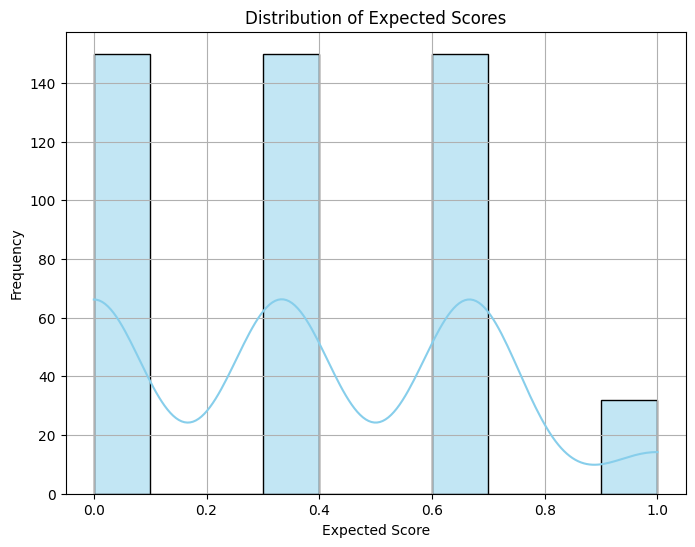

In [9]:
from trulens.benchmark.benchmark_frameworks.experiments.dataset_preprocessing import (
    visualize_expected_score_distribution,
)

visualize_expected_score_distribution(trec_doc_2022_true_labels)

In [38]:
import concurrent.futures
from trulens.apps.basic import TruBasicApp
from trulens.core import Feedback



custom_term_feedback = CustomTermFeedback()

f_tp = Feedback(custom_term_feedback.true_positive, name="True Positive", higher_is_better=True).on_output()
f_tn = Feedback(custom_term_feedback.true_negative, name="True Negative", higher_is_better=True).on_output()
f_fp = Feedback(custom_term_feedback.false_positive, name="False Positive", higher_is_better=False).on_output()
f_fn = Feedback(custom_term_feedback.false_negative, name="False Negative", higher_is_better=False).on_output()
f_abs_err = Feedback(custom_term_feedback.term_absolute_error, name="Absolute Error", higher_is_better=False).on_output()


CUSTOM_FEEDBACK_FUNCS = [f_tp, f_tn, f_fp, f_fn, f_abs_err]

def run_experiment_for_provider(provider, dataset_df):
    tru_wrapped_context_relevance_app = TruBasicApp(
        trulens_context_relevance,
        app_name="trec-dl-doc-2022-11102024",
        app_version=f"{provider.model_engine}-context-relevance",
        feedbacks=CUSTOM_FEEDBACK_FUNCS,
    )

    for i in range(len(dataset_df)):
        arg_1 = dataset_df[i]["query"]
        arg_2 = dataset_df[i]["expected_response"]
        arg_3 = dataset_df[i]["expected_score"]

        try:
            with tru_wrapped_context_relevance_app as _:
                tru_wrapped_context_relevance_app.app(provider, arg_1, arg_2, arg_3)

        except Exception as e:
            print(
                f"Error {e} in run_feedback_experiment row {i} with first arg {arg_1} and second arg {arg_2}"
            )

for provider in PROVIDERS:
    print(f"Running provider: {provider.model_engine}")
    run_experiment_for_provider(provider, trec_doc_2022)

# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(run_experiment_for_provider, provider, trec_doc_2022) for provider in PROVIDERS]
#     concurrent.futures.wait(futures)

✅ In True Positive, input output will be set to __record__.main_output or `Select.RecordOutput` .
✅ In True Negative, input output will be set to __record__.main_output or `Select.RecordOutput` .
✅ In False Positive, input output will be set to __record__.main_output or `Select.RecordOutput` .
✅ In False Negative, input output will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Absolute Error, input output will be set to __record__.main_output or `Select.RecordOutput` .
Running provider: gpt-4o


/Users/dhuang/Documents/git/trulens/src/feedback/trulens/feedback/llm_provider.py:286: UserWarning: No supporting evidence provided. Returning score only.
  warnings.warn(


KeyboardInterrupt: 

In [27]:
session.get_leaderboard()

Absolute Error  \
app_name                  app_version                                     
trec-dl-doc-2022-11102024 llama3.1-8b-context-relevance        0.337483   
                          gpt-4o-context-relevance             0.323651   
                          gpt-4o-mini-context-relevance        0.313278   

                                                         False Negative  \
app_name                  app_version                                     
trec-dl-doc-2022-11102024 llama3.1-8b-context-relevance        0.454357   
                          gpt-4o-context-relevance             0.524896   
                          gpt-4o-mini-context-relevance        0.468880   

                                                         False Positive  \
app_name                  app_version                                     
trec-dl-doc-2022-11102024 llama3.1-8b-context-relevance         0.03112   
                          gpt-4o-context-relevance              0.00000   
                          gpt-4o-mini-context-relevance         0.00000   

                                                         True Negative  \
app_name                  app_version                                    
trec-dl-doc-2022-11102024 llama3.1-8b-context-relevance       0.280083   
                          gpt-4o-context-relevance            0.311203   
                          gpt-4o-mini-context-relevance       0.311203   

                                                         True Positive  \
app_name                  app_version                                    
trec-dl-doc-2022-11102024 llama3.1-8b-context-relevance       0.234440   
                          gpt-4o-context-relevance            0.163900   
                          gpt-4o-mini-context-relevance       0.219917   

                                                          latency  total_cost  
app_name                  app_version                                          
trec-dl-doc-2022-11102024 llama3.1-8b-context-relevance  2.859005    0.000364  
                          gpt-4o-context-relevance       1.449336    0.009867  
                          gpt-4o-mini-context-relevance  1.628651    0.000321